In [1]:
import sys
print(sys.executable)

/rds/general/user/mb1024/home/myenv/bin/python


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F_nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import random
import torchvision.transforms as T
from glob import glob
from tqdm import tqdm
import timm

/rds/general/user/mb1024/home/myenv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class InMemoryContrastiveDataset(Dataset):
    def __init__(self, array_stack, transform=None):
        self.data = array_stack
        self.transform = transform

    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
       arr = self.data[idx].astype(np.float32)

       if np.std(arr) == 0:
           arr += np.random.normal(0, 1e-6, size=arr.shape)

    # Normalize and convert to tensor
       arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
       arr = np.expand_dims(arr, axis=0)  # shape: [1, H, W]
       img = torch.from_numpy(arr)

       if self.transform:
            aug1, aug2, original = self.transform(img)
            return aug1, aug2, original

       return img, img, img

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class simple_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.b1 = nn.BatchNorm2d(32)

        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.b2 = nn.BatchNorm2d(64)

        self.c3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.b3 = nn.BatchNorm2d(128)

        self.c4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.b4 = nn.BatchNorm2d(256)

        self.c5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.b5 = nn.BatchNorm2d(512)

        self.act = nn.ReLU()
        self.p = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AdaptiveAvgPool2d((1, 1))

        # Final linear projection to 128
        self.fc = nn.Linear(512, 128)

    def forward(self, x):
        x = self.p(self.act(self.b1(self.c1(x))))
        x = self.p(self.act(self.b2(self.c2(x))))
        x = self.p(self.act(self.b3(self.c3(x))))
        x = self.p(self.act(self.b4(self.c4(x))))
        x = self.p(self.act(self.b5(self.c5(x))))
        x = self.avg(x)                      # shape: [B, 512, 1, 1]
        x = x.view(x.size(0), -1)            # shape: [B, 512]
        x = self.fc(x)                       # shape: [B, 128]
        return x

In [5]:
final_stack = np.load("final_stack.npy")

In [6]:
class contrastive_transforms:
    def __init__(self):
        self.transform = T.Compose([
    T.RandomResizedCrop(size=160, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=15),
    T.GaussianBlur(kernel_size=5),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),
    T.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)) # adjust for your dataset
])

    def __call__(self, x):
        return self.transform(x), self.transform(x), x

In [41]:
# --- Load Custom Dataset ---
train_dataset = InMemoryContrastiveDataset(final_stack, transform=contrastive_transforms())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [8]:
# Initial SimCLR model placeholder
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        
        return z

In [9]:
def nt_xent_loss(z_i, z_j, temperature=0.4):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2B, D]
    z = F.normalize(z, dim=1)  # Safer: remove noise for now

    # Cosine similarity matrix
    similarity_matrix = torch.matmul(z, z.T) / temperature  # [2B, 2B]

    # Remove self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))  # safer than -9e15

    # Positive pair indices
    labels = torch.arange(batch_size, device=z.device)
    labels = torch.cat([labels + batch_size, labels])

    # Logits
    logits = torch.clamp(similarity_matrix, min=-50.0, max=50.0)  # prevent overflow
    loss = -F.log_softmax(logits, dim=1)[torch.arange(2 * batch_size), labels].mean()

    return loss

In [38]:
import torch
import torch.optim as optim
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate model and optimizer
model = SimCLR(simple_cnn()).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Load checkpoint from your unique run folder
checkpoint_path = "contrastive_checkpoints_run_20250708-162049/checkpoint_epoch_30.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resuming from epoch {checkpoint['epoch']}")
else:
    print("⚠️ No checkpoint found.")
    start_epoch = 0

✅ Resuming from epoch 30


In [ ]:
import pandas as pd 
df = pd.read_pickle("/rds/general/user/mb1024/home/output.pkl")

In [40]:
final_stack = np.load("final_stack.npy")

In [ ]:
print(df['image_vector'][0])

In [ ]:
len(df['image_vector'][0])

In [ ]:
import torch
import numpy as np
import skfuzzy as fuzz
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm


# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.encoder.to(device)
model.encoder.eval()

# Extract features
all_features = []

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Extracting features"):
        inputs = batch[0].to(device)  # shape: (B, 1, 204, 216)
        features = model.encoder(inputs)  # shape: (B, latent_dim)
        all_features.append(features.cpu())

# Stack all features into a single NumPy array
features_np = torch.cat(all_features, dim=0).numpy()  # shape: (40613, latent_dim)

# Transpose for FCM: (latent_dim, num_samples)
features_T = features_np.T

# Fuzzy C-Means Clustering
n_clusters = 10  # You can change this based on your application
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=features_T,
    c=n_clusters,
    m=2.0,
    error=0.005,
    maxiter=1000,
    init=None
)

# Fuzzy membership matrix: shape (num_samples, n_clusters)
membership_matrix = u.T

print("Fuzzy membership matrix shape:", membership_matrix.shape)

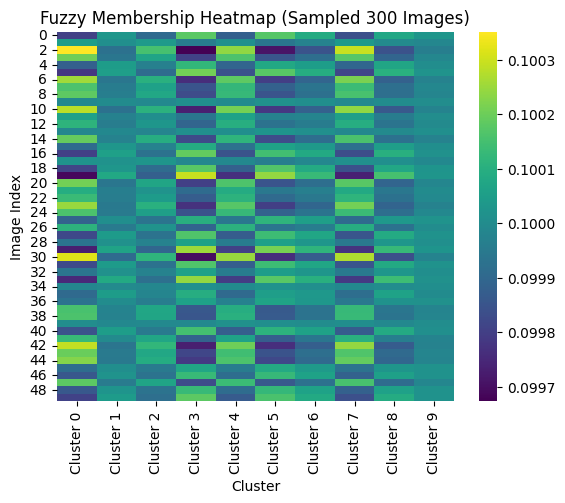

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: randomly sample a subset for readability
sample_indices = np.random.choice(membership_matrix.shape[0], size=50, replace=False)
sampled_memberships = membership_matrix[sample_indices]

sns.heatmap(sampled_memberships, cmap="viridis", xticklabels=[f"Cluster {i}" for i in range(membership_matrix.shape[1])])
plt.title("Fuzzy Membership Heatmap (Sampled 300 Images)")
plt.xlabel("Cluster")
plt.ylabel("Image Index")
plt.show()

In [49]:
hard_labels = np.argmax(membership_matrix, axis=1)

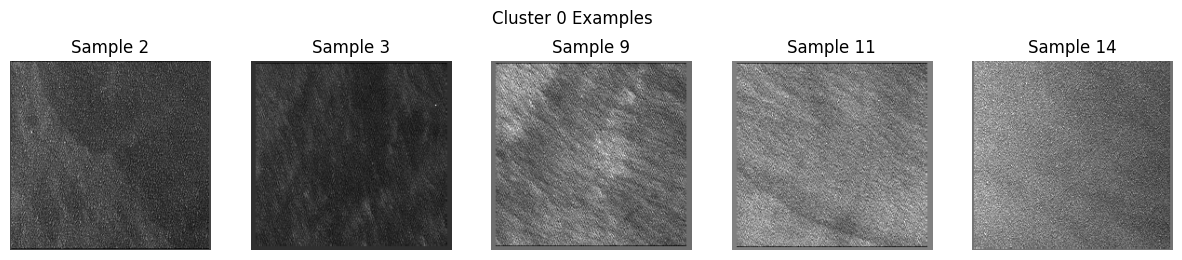

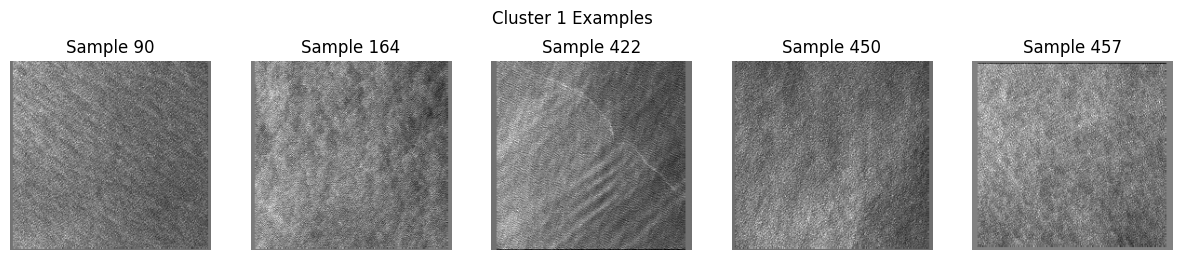

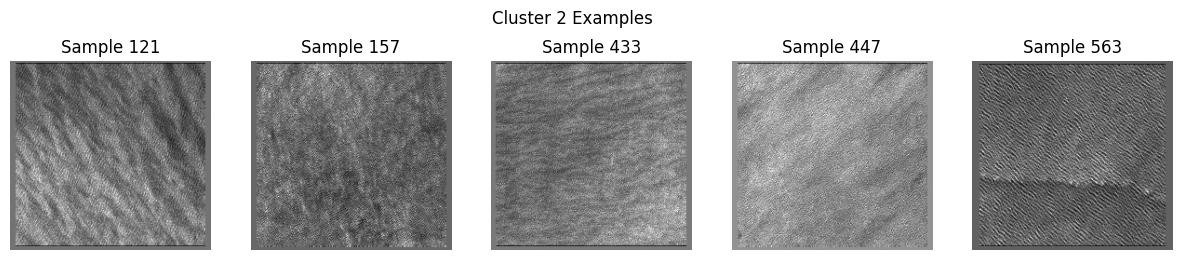

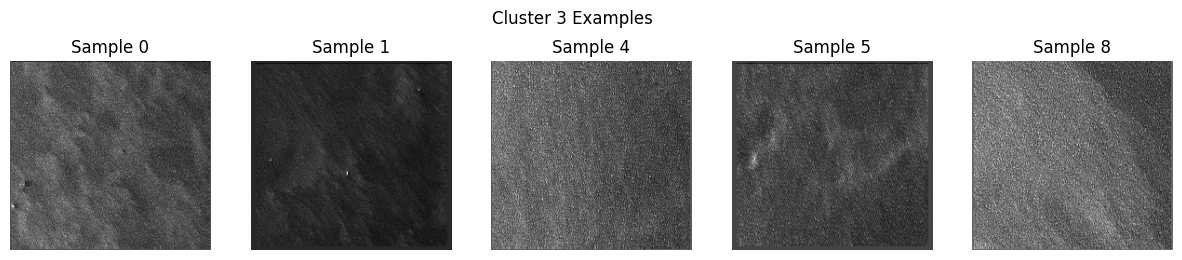

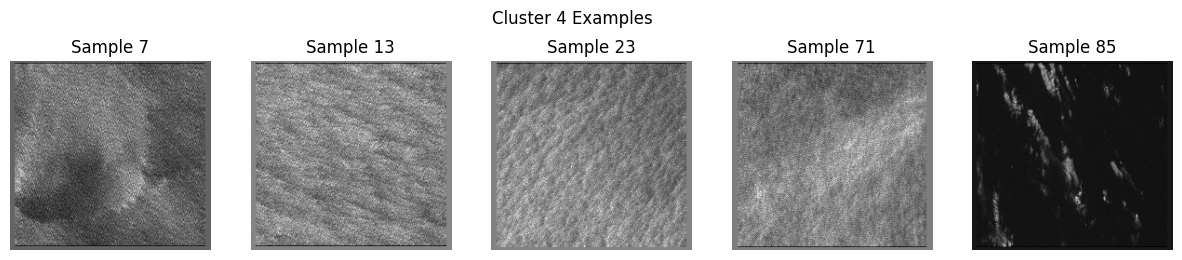

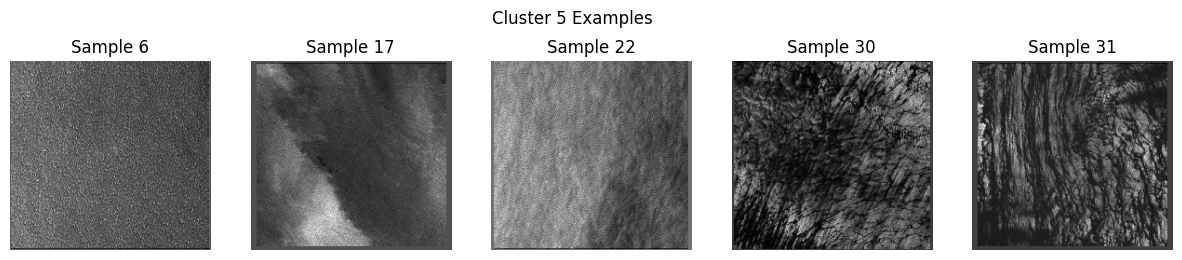

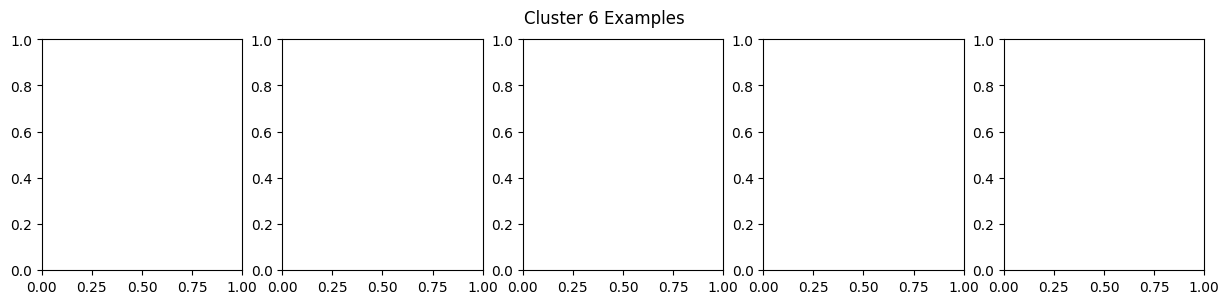

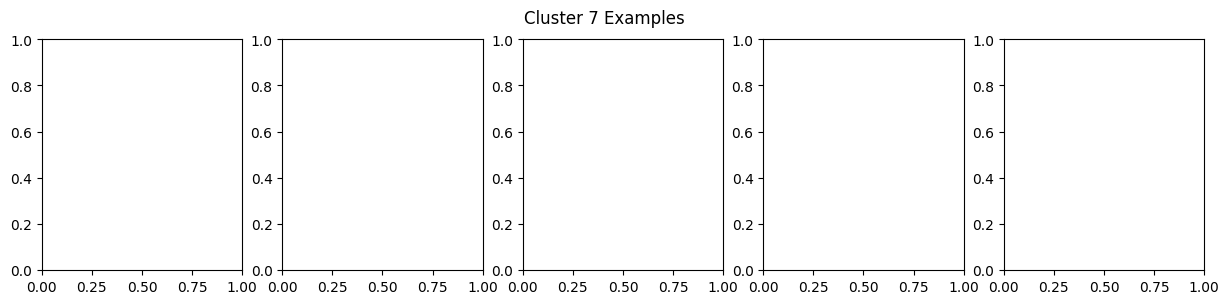

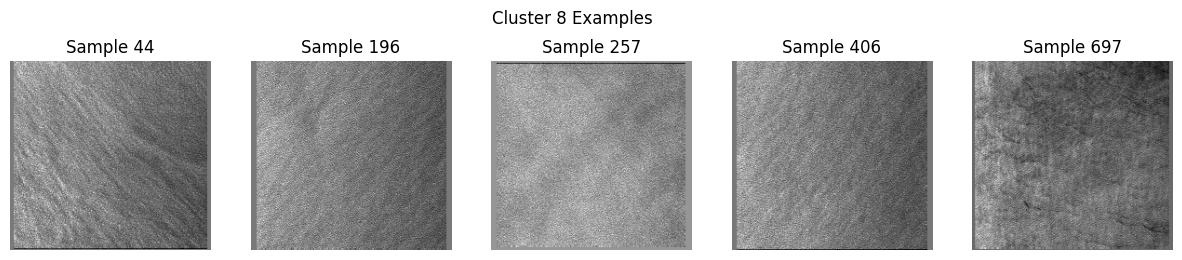

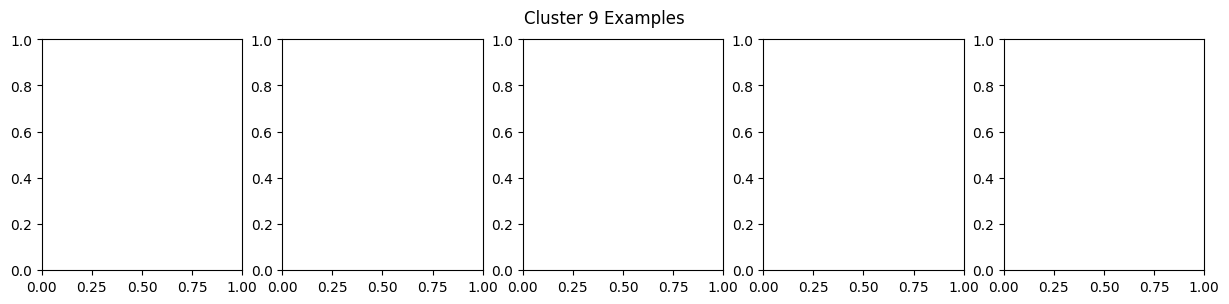

In [50]:
import matplotlib.pyplot as plt

def show_cluster_examples(final_stack, hard_labels, cluster_id, num_samples=5):
    idxs = np.where(hard_labels == cluster_id)[0][:num_samples]
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(idxs):
        axs[i].imshow(final_stack[idx], cmap='gray')  # or 'jet' if it's colored geophysical
        axs[i].axis('off')
        axs[i].set_title(f"Sample {idx}")
    plt.suptitle(f"Cluster {cluster_id} Examples")
    plt.show()

# Show examples for each cluster
for cluster_id in range(membership_matrix.shape[1]):
    show_cluster_examples(final_stack, hard_labels, cluster_id)

In [51]:
# `cntr` contains the cluster centroids in latent space
# You could optionally decode them (if you have a decoder), or just compare feature-wise

import pandas as pd

centroid_df = pd.DataFrame(cntr, columns=[f"Feature_{i}" for i in range(cntr.shape[1])])
print("Cluster Centroid Feature Summary:")
print(centroid_df.describe())

Cluster Centroid Feature Summary:
       Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.300476   0.981813  10.277404  -2.349441  -2.406192  -0.269868   
std     0.002131   0.002044   0.001463   0.002684   0.004989   0.001152   
min     0.297600   0.979075  10.275359  -2.353287  -2.413372  -0.271530   
25%     0.299062   0.980521  10.276148  -2.351934  -2.410694  -0.270883   
50%     0.299965   0.981353  10.277479  -2.348786  -2.405037  -0.269613   
75%     0.302439   0.983629  10.278293  -2.347639  -2.402972  -0.269147   
max     0.303533   0.984759  10.279758  -2.345814  -2.399488  -0.268328   

       Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_118  \
count  10.000000  10.000000  10.000000  10.000000  ...    10.000000   
mean    1.529367   0.841292  -0.356785   5.407840  ...     0.412552   
std     0.000237   0.000139   0.001284   0.002162  ...     0.001341   
min   

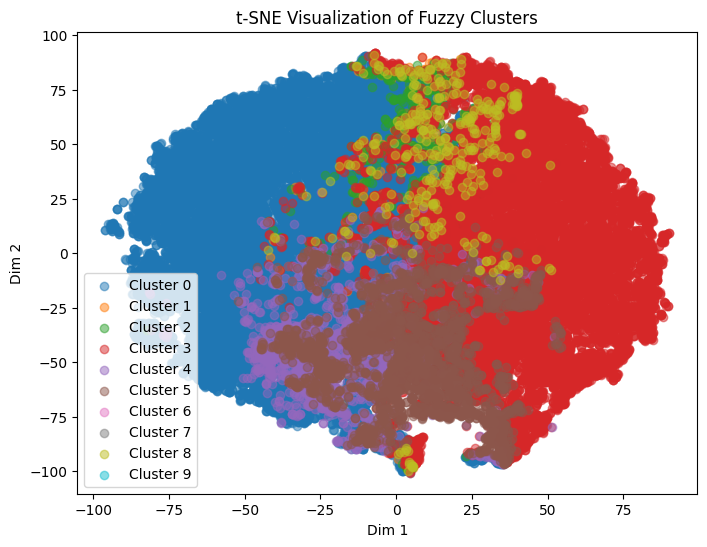

In [52]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Reduce features to 2D
reducer = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = reducer.fit_transform(features_np)

# Plot by hard cluster
plt.figure(figsize=(8, 6))
for i in range(membership_matrix.shape[1]):
    idxs = np.where(hard_labels == i)[0]
    plt.scatter(reduced_features[idxs, 0], reduced_features[idxs, 1], label=f'Cluster {i}', alpha=0.5)

plt.legend()
plt.title("t-SNE Visualization of Fuzzy Clusters")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import ast

# Fix binary label columns using ast.literal_eval
def try_literal_eval(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

for col in ['DV', 'RF', 'JS', 'CW', 'AA']:
    df[col] = df[col].apply(try_literal_eval)

# Fix image_vector column using np.fromstring
def parse_vector(val):
    if isinstance(val, str):
        return np.fromstring(val.strip("[]"), sep=' ')
    return val

df['image_vector'] = df['image_vector'].apply(parse_vector)

# ----------------------------------------
# Step 3: Convert image_vector column to 2D NumPy array
# ----------------------------------------
X = np.array(df["image_vector"].tolist())  # shape: (n_samples, 16384)

# ----------------------------------------
# Step 4: Loop through each label group and train logistic regression
# ----------------------------------------
label_groups = ['DV', 'RF', 'JS', 'CW', 'AA']

for label in label_groups:
    print(f"\n=== Training logistic regression for label group: {label} ===")

    # Convert label column to 2D array: (n_samples, 12)
    Y = np.array(df[label].tolist())

    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # Train model
    base_model = LogisticRegression(max_iter=1000)
    model = MultiOutputClassifier(base_model)
    model.fit(X_train, Y_train)

    # Predict
    Y_pred = model.predict(X_test)

    # Evaluate
    print(f"--- Evaluation for label group: {label} ---")
    print(classification_report(Y_test, Y_pred, zero_division=0))

In [ ]:
print(df['image_vector'])

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import ast

# Make sure your model is in eval mode and on the right device
model.encoder.eval()
model = model.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample transform: just resizing and ToTensor (no Normalize)
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()  # will be already [0, 1] after local normalization
])

# ------------------------
# Reconstruct grayscale image from flat vector
# ------------------------
def vector_to_tensor(vec):
    try:
        # Reshape to (225, 225)
        arr = np.array(vec).reshape((225, 225)).astype(np.float32)

        # Local min-max normalization to [0, 1]
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

        # Convert to grayscale PIL image (no RGB!)
        img = Image.fromarray((arr * 255).astype(np.uint8))  # grayscale

        # Apply transform (no RGB conversion)
        tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)  # [1, 1, 225, 225]
        return tensor
    except Exception as e:
        print(f"Image conversion failed: {e}")
        return None

# ------------------------
# Extract SSL features from image vector
# ------------------------
def extract_ssl_from_vector(vec):
    tensor = vector_to_tensor(vec)
    if tensor is None:
        return np.zeros(512)  # or whatever feature dim your model returns
    with torch.no_grad():
        feats = model(tensor)
    return feats.squeeze(0).cpu().numpy()

# ------------------------
# Load and fix DataFrame
# ------------------------
label_cols = ['DV', 'RF', 'JS', 'CW', 'AA']

# Ensure labels are parsed correctly
for col in label_cols:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# If image_vector is still string, fix it
def parse_vector(val):
    if isinstance(val, str):
        return np.fromstring(val.strip("[]"), sep=' ')
    return val

df['image_vector'] = df['image_vector'].apply(parse_vector)

# ------------------------
# Extract SSL features and combine (optional)
# ------------------------
print("Extracting SSL features...")
df['ssl_vector'] = df['image_vector'].apply(extract_ssl_from_vector)

# Option 1: Use SSL features only
X = np.stack(df['ssl_vector'].to_numpy())

# Option 2: Combine raw + SSL
# df['combined_vector'] = df.apply(lambda row: np.concatenate([row['image_vector'], row['ssl_vector']]), axis=1)
# X = np.stack(df['combined_vector'].to_numpy())

# ------------------------
# Train logistic regression models for each label
# ------------------------
for label in label_cols:
    print(f"\n=== Training logistic regression for label group: {label} ===")

    Y = np.array(df[label].tolist())  # shape: (n_samples, 12)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    base_model = LogisticRegression(max_iter=5000, class_weight='balanced')
    model_lr = MultiOutputClassifier(base_model)
    model_lr.fit(X_train, Y_train)

    Y_pred = model_lr.predict(X_test)

    print(f"--- Evaluation for label group: {label} ---")
    print(classification_report(Y_test, Y_pred, zero_division=0))

In [ ]:
import numpy as np

columns = ['DV', 'RF', 'JS', 'CW', 'AA']

# Convert each list column into a 2D array: shape (n_samples, n_labels)
label_matrices = {col: np.stack(df[col].to_numpy()) for col in columns}


In [ ]:
# Compute total variance (flattened)
for col in columns:
    flattened = label_matrices[col].flatten()
    var = np.var(flattened)
    print(f"Variance for {col}: {var:.4f}")


In [ ]:
# Get per-label variance (not flattened)
for col in columns:
    matrix = label_matrices[col]  # shape: (n_samples, n_labels)
    var_per_label = np.var(matrix, axis=0)
    print(f"\n{col} - Variance per label index:")
    print(var_per_label)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create matrix of shape (n_samples, 60)
label_matrix = np.stack([
    np.concatenate([row['DV'], row['RF'], row['JS'], row['CW'], row['AA']])
    for _, row in df.iterrows()
])

# Compute pairwise cosine similarity (optional)
cos_sim_matrix = cosine_similarity(label_matrix)

# Or compare each row to the mean row
mean_vector = label_matrix.mean(axis=0)
row_similarities = cosine_similarity(label_matrix, mean_vector.reshape(1, -1)).flatten()

df['row_cosine_sim'] = row_similarities


In [ ]:
print(df['row_cosine_sim'].describe())


In [19]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np


root_dir = '/rds/general/user/mb1024/home/SA/TIFF_processed/GeoTIFF'

class TiffDataset(Dataset):
    def __init__(self, root_dir, transform=None, to_rgb=False):
        self.samples = []
        self.labels = []
        self.label_map = {}
        self.transform = transform
        self.to_rgb = to_rgb

        for idx, label_name in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_path):
                self.label_map[label_name] = idx
                for fname in os.listdir(label_path):
                    if fname.endswith('.tiff'):
                        self.samples.append(os.path.join(label_path, fname))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.labels[idx]

        with Image.open(path) as img:
            arr = np.array(img).astype(np.float32)
            arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)  # normalize 0–1

            if self.to_rgb:
                arr = np.stack([arr] * 3, axis=0)  # [3, H, W]
            else:
                arr = np.expand_dims(arr, axis=0)  # [1, H, W]

            tensor_img = torch.from_numpy(arr)

            if self.transform:
                tensor_img = self.transform(tensor_img)

        return tensor_img, label, path

In [ ]:
pip list

In [36]:
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights


dataset_imgnet = TiffDataset(root_dir, to_rgb=False)
print(len(dataset_imgnet))
# Load model
# Load a pretrained ResNet model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the first convolutional layer to accept 1-channel (grayscale) input
# Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Optionally reinitialize the weights of conv1
nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')

# Replace the final classification layer (if doing transfer learning)
model.fc = nn.Linear(model.fc.in_features, 10)  # Set your number of classes

imagenet_model = model.to(device)
imagenet_model.eval().to(device)

# Create dataloader
imgnet_loader = DataLoader(dataset_imgnet, batch_size=32, shuffle=False)

# Extract features
all_imgnet_features = []
all_labels = []
all_paths = []

with torch.no_grad():
    for imgs, labels, paths in imgnet_loader:
        imgs = imgs.to(device)
        feats = imagenet_model(imgs)
        all_imgnet_features.append(feats.cpu())
        all_labels.extend(labels.cpu().numpy().tolist())  # FIXED
        all_paths.extend(paths)

imagenet_features = torch.cat(all_imgnet_features).numpy()
labels = np.array(all_labels)
paths = np.array(all_paths)

print(imagenet_features.shape)
print(labels.shape)

997
(997, 10)
(997,)


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Train/test split (features, labels, paths)
X_train, X_test, y_train, y_test = train_test_split(
    imagenet_features, labels, test_size=0.2, random_state=42
)

# Step 2: Normalize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train classifier
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_scaled, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

# Step 5: Output results
print(f"🔍 Classification Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))



🔍 Classification Accuracy: 0.4900
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        24
           1       0.34      0.55      0.42        20
           2       0.19      0.13      0.15        31
           3       0.54      0.72      0.62        18
           4       0.71      0.57      0.63        30
           5       0.36      0.45      0.40        20
           6       0.50      0.50      0.50        10
           7       0.80      0.25      0.38        16
           8       0.56      0.56      0.56        27
           9       0.00      0.00      0.00         4

    accuracy                           0.49       200
   macro avg       0.46      0.46      0.44       200
weighted avg       0.49      0.49      0.47       200



/rds/general/user/mb1024/home/myenv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/rds/general/user/mb1024/home/myenv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/rds/general/user/mb1024/home/myenv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"